# Regularization - Ridge & Lasso

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

In [6]:
# import the train and test data prepared before and stored in a pickle file

with open('data/houses_prepared_encoded.pkl', 'rb') as f:
    houses_train_encoded = pickle.load(f)
    houses_test_encoded = pickle.load(f)

houses_test_encoded.head()

,Order,PID,Lot_Frontage,Lot_Area,Lot_Shape,Land_Slope,Overall_Qual,Overall_Cond,Year_Built,Year_Remod_Add,...,Sale_Type_New,Sale_Type_Other,Sale_Type_WD,Sale_Condition_Family,Sale_Condition_Normal,Sale_Condition_Other,Sale_Condition_Partial,Land_Contour_HLS,Land_Contour_Low,Land_Contour_Lvl
0,1,526301100,141,31770,1.0,0.0,4.0,5.0,1960,1960,...,0,0,1,0,1,0,0,0,0,1
1,2,526350040,80,11622,0.0,0.0,5.0,4.0,1961,1961,...,0,0,1,0,1,0,0,0,0,1
2,3,526351010,81,14267,1.0,0.0,4.0,4.0,1958,1958,...,0,0,1,0,1,0,0,0,0,1
3,4,526353030,93,11160,0.0,0.0,3.0,5.0,1968,1968,...,0,0,1,0,1,0,0,0,0,1
4,5,527105010,74,13830,1.0,0.0,5.0,5.0,1997,1998,...,0,0,1,0,1,0,0,0,0,1


## How Ridge and Lasso work?

In [11]:
# lets visualize the effect of parameter shrinkage on 10 selected numerical features

selected_features = [
    'Sale_Price', 'Lot_Frontage', 'Lot_Area', 'Year_Built',
    'Total_Bsmt_SF', 'First_Flr_SF', 'Gr_Liv_Area',
    'TotRms_AbvGrd', 'Garage_Area'
]

# IMPORTANT !!!
# for the purpose of the Ridge or LASSO regression the numerical variables
# have to be standardized to z-scores !!!

# create and fit StandardScaler
scaler = StandardScaler()

# directly create the new scaled DataFrame from fit_transform output
houses_train_scaled = pd.DataFrame(
    scaler.fit_transform(houses_train_encoded.loc[:, selected_features]),
    columns = selected_features,
    index = houses_train_encoded.index
)

# for the test set, apply transform (not fit_transform)
houses_test_scaled = pd.DataFrame(
    scaler.transform(houses_test_encoded.loc[:, selected_features]),
    columns = selected_features,
    index = houses_test_encoded.index
)

In [13]:
houses_test_scaled.head()

,Sale_Price,Lot_Frontage,Lot_Area,Year_Built,Total_Bsmt_SF,First_Flr_SF,Gr_Liv_Area,TotRms_AbvGrd,Garage_Area
0,0.410104,2.460311,2.743866,-0.374874,0.061197,1.247164,0.285327,0.339047,0.255369
1,-0.958287,0.655603,0.170777,-0.341764,-0.389738,-0.667951,-1.163313,-0.928951,1.185204
2,-0.124813,0.685189,0.508568,-0.441094,0.628282,0.423161,-0.337970,-0.294952,-0.738910
3,0.770861,1.040213,0.111775,-0.109992,2.406970,2.391193,1.150698,0.973046,0.227750
4,0.097862,0.478091,0.452759,0.850204,-0.284976,-0.587314,0.233862,-0.294952,0.043624


## Ridge

In [15]:
# lets specify 200 values of the shrinkage penalty between 10^(-2) and 1e5
# (at equal intervals on a logarithmic scale)
# ex: from the value close to 0 (OLS) to a very high penalty for the values of betas

alphas = np.logspace(-2, 5, 200)

# split the data into features (X) and target (y)
houses_train_X = houses_train_scaled.drop('Sale_Price', axis = 1)
houses_train_y = houses_train_scaled['Sale_Price']

In [17]:
# Prepare a list for collecting the coefficients
ridge_coefficients = []

# loop over lambdas (in python alphas)
for alpha in alphas:
    houses_ridge = Ridge(
        alpha = alpha,
        fit_intercept = True
    )
    # fit the model
    houses_ridge.fit(houses_train_X, houses_train_y)
    # store latest coefficients
    ridge_coefficients.append(houses_ridge.coef_)

# convert a list of dicts to a DataFrame
ridge_coefficients_df = pd.DataFrame(ridge_coefficients)

ridge_coefficients_df.head()

# we have betas in subsequent variables in columns and lambdas in rows

,0,1,2,3,4,5,6,7
0,0.026683,0.010798,0.267617,0.164845,0.015558,0.549722,-0.098495,0.173382
1,0.026683,0.010798,0.267617,0.164845,0.015559,0.549721,-0.098494,0.173383
2,0.026683,0.010798,0.267617,0.164845,0.015559,0.549720,-0.098493,0.173383
3,0.026683,0.010798,0.267617,0.164845,0.015559,0.549718,-0.098492,0.173383
4,0.026683,0.010798,0.267617,0.164845,0.015560,0.549717,-0.098491,0.173383


In [19]:
# for each lambda value we have a set of coefficients.
# the size of matrix of coefficients is therefore equal to 200
# (number of lambda values) by 9 (number of variables)

ridge_coefficients_df.shape

(200, 8)

<Axes: ylabel='0'>

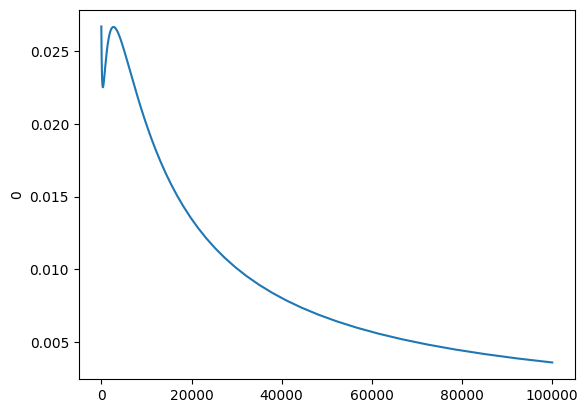

In [23]:
# estimated coefficients for the FIRST variable (Lot_Frontage) is in the first column
sns.lineplot(
    x = alphas,
    y = ridge_coefficients_df.iloc[:, 0]
)

# lets check how these parameters changes with lambda

# we expect that for larger lambdas coefficients will be closer to 0 -> 
# and that is what we observe here...

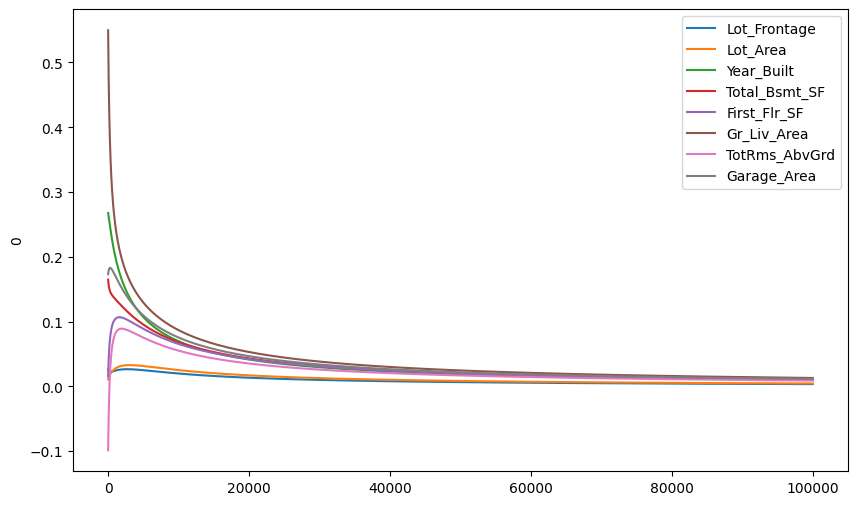

In [29]:
# create a color palette with 8 distinct colors
colors = sns.color_palette('tab10', n_colors = 8)

plt.figure(figsize=(10, 6))
for i_col in range(8):
    sns.lineplot(
        x = alphas,
        y = ridge_coefficients_df.iloc[:, i_col],
        color = colors[i_col],
        label = houses_train_X.columns[i_col]
    )


# Interestingly, as lambda increases initially some parameters may be rising 
# or even switching signs (!) to finally start falling asymptotically to 0

## LASSO

In [34]:
# lets compare the analogous graph for the LASSO method, 
# but lets use a much smaller range of lambdas/alphas

alphas2 = np.logspace(-4, 1, 200, base = 2)

lasso_coefficients = []

for alpha in alphas2:
    houses_lasso = Lasso(
        alpha = alpha,
        fit_intercept = True
    )
    houses_lasso.fit(houses_train_X, houses_train_y)
    lasso_coefficients.append(houses_lasso.coef_)

lasso_coefficients_df = pd.DataFrame(lasso_coefficients)

lasso_coefficients_df.head()

,0,1,2,3,4,5,6,7
0,0.0,0.0,0.230833,0.155188,0.014534,0.435118,0.0,0.163870
1,0.0,0.0,0.230160,0.154958,0.014266,0.434578,0.0,0.163600
2,0.0,0.0,0.229475,0.154723,0.013993,0.434029,0.0,0.163326
3,0.0,0.0,0.228778,0.154485,0.013715,0.433470,0.0,0.163047
4,0.0,0.0,0.228069,0.154242,0.013432,0.432901,0.0,0.162762


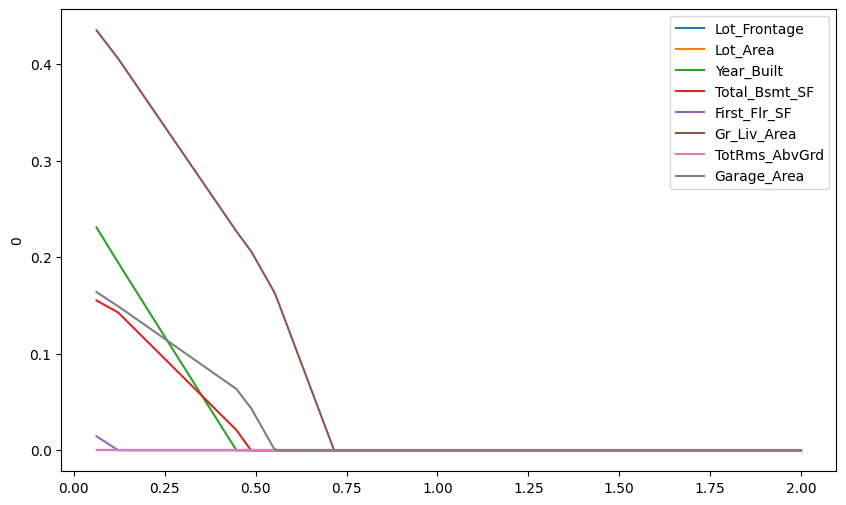

In [40]:
plt.figure(figsize = (10, 6))
for i in range(8):
    sns.lineplot(
        x = alphas2, 
        y = lasso_coefficients_df.iloc[:, i],
        color = colors[i],
        label = houses_train_X.columns[i]
    )


# here for lambda above 0.75 all parameters become 0, the last variable left is 
# 'Gr_Live_Area'. That is how LASSO may be used as initial variable selection method.

## LASSO regression on full houses dataset

In [53]:
# lets apply it to the dataset with all variables to check which value of lambda/alpha is
# optimal and which variables will be selected by LASSO

houses_train_full_X = houses_train_encoded.drop(['Sale_Price', 'Order', 'PID'], axis = 1)
houses_train_full_y = houses_train_encoded['Sale_Price']

alphas = np.logspace(-3, 4, 50)

# to correctly approach the normalization within EACH step of cross-validation in sklearn
# we need to define a Pipeline

lasso_pipeline = Pipeline(
    [
        ('scaler', StandardScaler()), # feature scaling to z-scores ONLY on training data
        ('model', Lasso()) # Model       
    ]
)

# here we use 5-Fold Cross-Validation
cv5 = KFold(
    n_splits = 5,
    shuffle = True,
    random_state = 123
)

# define grid of hyperparameters
# Note the syntax 'model__alpha': because our pipeline step is named "model"

param_grid = {
    'model__alpha': alphas
}

lasso_search = GridSearchCV(
    estimator = lasso_pipeline,
    param_grid = param_grid,
    scoring = 'neg_mean_absolute_error',  # could be R2 too
    cv = cv5,
    n_jobs = -1  # use all available CPU cores (optional)
)

lasso_search.fit(houses_train_full_X, houses_train_full_y)

print('Best alpha:', lasso_search.best_params_)
print('Best (negative) MAE:', lasso_search.best_score_)

# sklearn produces -MAE (and also -MSE) to follow the rule: the higher the better

Best alpha: {'model__alpha': 719.6856730011514}
Best (negative) MAE: -18137.806823814106


In [49]:
# if you want the full results for each alpha
results_df = pd.DataFrame(lasso_search.cv_results_)
print(results_df[['param_model__alpha', 'mean_test_score', 'rank_test_score']])

    param_model__alpha  mean_test_score  rank_test_score
0             0.001000    -19212.020688               45
1             0.001389    -19212.016444               44
2             0.001931    -19212.010547               43
3             0.002683    -19212.002353               42
4             0.003728    -19211.990968               41
5             0.005179    -19211.975148               40
6             0.007197    -19211.953167               39
7             0.010000    -19211.922623               38
8             0.013895    -19211.880186               37
9             0.019307    -19211.821220               36
10            0.026827    -19211.744855               35
11            0.037276    -19211.636191               34
12            0.051795    -19211.482439               33
13            0.071969    -19211.272909               32
14            0.100000    -19210.978554               31
15            0.138950    -19210.568583               30
16            0.193070    -1920

<Axes: xlabel='param_model__alpha', ylabel='mean_test_score'>

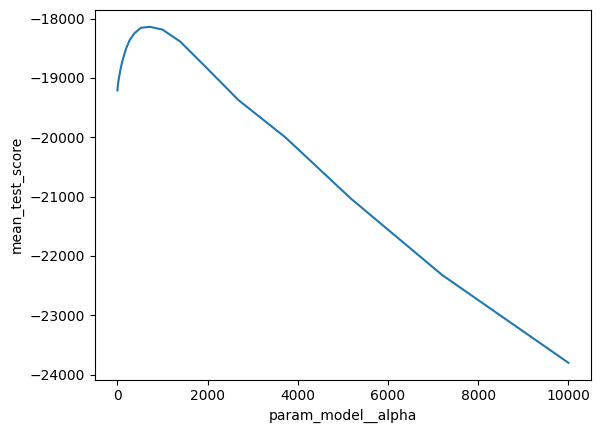

In [51]:
sns.lineplot(
    x = 'param_model__alpha',
    y = 'mean_test_score',
    data = results_df
)

# one can see a clear turning point

In [61]:
# lets check how best lambda changes if we optimize R2
# based on the same grid of hyperparameters

lasso_search2 = GridSearchCV(
    estimator = lasso_pipeline,
    param_grid = param_grid,
    scoring = 'r2', # change happens only here !!!
    cv = cv5,
    n_jobs = -1
)

lasso_search2.fit(houses_train_full_X, houses_train_full_y)

print('Best alpha:', lasso_search2.best_params_)
print('Best R2:', lasso_search2.best_score_)

results2_df = pd.DataFrame(lasso_search2.cv_results_)
# print(results2_df[['param_model__alpha', 'mean_test_score', 'rank_test_score']])

Best alpha: {'model__alpha': 517.9474679231203}
Best R2: 0.8508859585431019


<Axes: xlabel='param_model__alpha', ylabel='mean_test_score'>

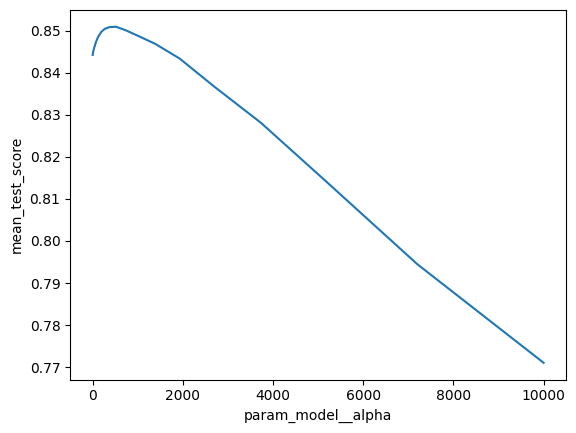

In [63]:
sns.lineplot(
    x = 'param_model__alpha',
    y = 'mean_test_score',
    data = results2_df
)

# similar shape

In [82]:
# analyze the best LASSO model

# The best model (including the entire pipeline - both the scaler and the LASSO model)
# is already fitted to the entire training set and is available as a 
# .best_estimator_  element

houses_lasso_best = lasso_search2.best_estimator_

# we can access its "model" part easily
model_ = houses_lasso_best['model']

# lets extract all coefficients and align them with the predictors' names
coef_array = model_.coef_
predictor_names = houses_train_full_X.columns

# Build a DataFrame of all predictors + their coefficients
lasso_coef_df = pd.DataFrame(
    {
        'predictor': predictor_names,
        'coefficient': coef_array
    }
)

lasso_coef_df.head(6)

,predictor,coefficient
0,Lot_Frontage,0.000000
1,Lot_Area,1125.505836
2,Lot_Shape,0.000000
3,Land_Slope,1816.824371
4,Overall_Qual,-14714.045956
5,Overall_Cond,-4639.638299


In [84]:
# lets add the absolute value of the coefficient
# and sort the dataframe by this column in descending order

lasso_coef_df['abs_coef'] = lasso_coef_df['coefficient'].abs()
lasso_coef_df.sort_values(by='abs_coef', ascending = False, inplace = True)

lasso_coef_df.head(10)

,predictor,coefficient,abs_coef
21,Gr_Liv_Area,25736.592920,25736.592920
4,Overall_Qual,-14714.045956,14714.045956
76,Neighborhood_Northridge_Heights,10688.296050,10688.296050
75,Neighborhood_Northridge,7716.682946,7716.682946
84,Neighborhood_Stone_Brook,7502.481126,7502.481126
12,Bsmt_Exposure,-6971.389129,6971.389129
44,MS_SubClass_One_Story_1946_and_Newer_All_Styles,5475.621194,5475.621194
28,Kitchen_Qual,-5362.465788,5362.465788
5,Overall_Cond,-4639.638299,4639.638299
8,Exter_Qual,-4177.420895,4177.420895


In [88]:
# check how many coefficients were kept and how many removed

(lasso_coef_df.coefficient != 0).value_counts()

# 89 variables were kept (most of them are dummies from recoding categorical predictors)

coefficient
True     89
False    62
Name: count, dtype: int64

In [90]:
# we can store the best LASSO model as a pickle file for further comparisons

# if the saved object is not a dataframe, we need to use different syntax
with open('data/model_houses_lasso_best.pkl', 'wb') as f:
    pickle.dump(houses_lasso_best, f)

## Ridge Regression on full house dataset

In [95]:
# similarly, find the optimal variant of Ridge regression for the whole dataset
alphas = np.logspace(-3, 4, 50)

# to correctly approach the normalization within EACH step of cross-validation in sklern
# we need to define a Pipeline

ridge_pipeline = Pipeline(
    [
        ('scaler', StandardScaler()), # z-score scaling
        ('model', Ridge()) # model
    ]
)

param_grid = {'model__alpha': alphas}

ridge_search = GridSearchCV(
    estimator = ridge_pipeline,
    param_grid = param_grid,
    scoring = 'neg_mean_absolute_error',
    cv = cv5,
    n_jobs = -1
)

ridge_search.fit(houses_train_full_X, houses_train_full_y)

print('Best alpha:', ridge_search.best_params_)
print('Best (negative) MAE:', ridge_search.best_score_)

Best alpha: {'model__alpha': 517.9474679231203}
Best (negative) MAE: -18266.627209164006


<Axes: xlabel='param_model__alpha', ylabel='mean_test_score'>

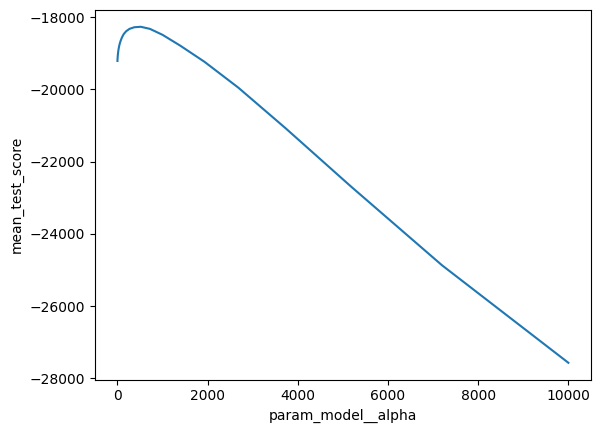

In [97]:
# check how the MAE depends on lambda/alpha in case of ridge regression:
ridge_search_df = pd.DataFrame(ridge_search.cv_results_)

sns.lineplot(
    x = 'param_model__alpha',
    y = 'mean_test_score',
    data = ridge_search_df
)

In [99]:
houses_ridge_best = ridge_search.best_estimator_

with open('data/model_houses_ridge_best.pkl', 'wb') as f:
    pickle.dump(houses_ridge_best, f)

## Elastic Net on full houses dataset

In [104]:
# estimate the combination of LASSO and Ridge - the Elastic Net

# keep the range of lambdas/alphas as thinner than before and use less values
alphas = np.logspace(-1, 4, 20)

# define the set of alphas (in python called L1_ratio) which takes values from [0, 1].
# 0.0 = pure Ridge, 1.0 = pure LASSO, in-between is Elastic Net
l1_ratios = np.linspace(0, 1, 5) # ex: 0, 0.2, ..., 1.0

elastic_pipeline = Pipeline(
    [
        ('scaler', StandardScaler()), # z-score Feature Scaling
        # ElasticNet model
        ('model', ElasticNet(
            max_iter = 2000, # default is 1000, but it may not converge
            tol = 0.01 # default is 1e-4, but it may not converge
        ))
    ]
)


param_grid = {
    'model__alpha': alphas, 
    'model__l1_ratio': l1_ratios
}

elastic_search = GridSearchCV(
    estimator = elastic_pipeline,
    param_grid = param_grid,
    scoring = 'neg_mean_absolute_error', # or another appropriate metric
    cv = cv5, # again the same 5-Fold CV as defined before
    n_jobs = -1
)

elastic_search.fit(houses_train_full_X, houses_train_full_y)

print('Best alpha:', elastic_search.best_params_['model__alpha'])
print('Best l1_ratio:', elastic_search.best_params_['model__l1_ratio'])
print('Best (negative) MAE:', elastic_search.best_score_)

# The best estimator (pipeline) including the best alpha and l1_ratio
best_elastic_model = elastic_search.best_estimator_

# optimal elastic-net is a pure LASSO model (l1_ratio = 1)
# we have it already, so we do not store it once again

Best alpha: 483.2930238571752
Best l1_ratio: 1.0
Best (negative) MAE: -18166.75960164908


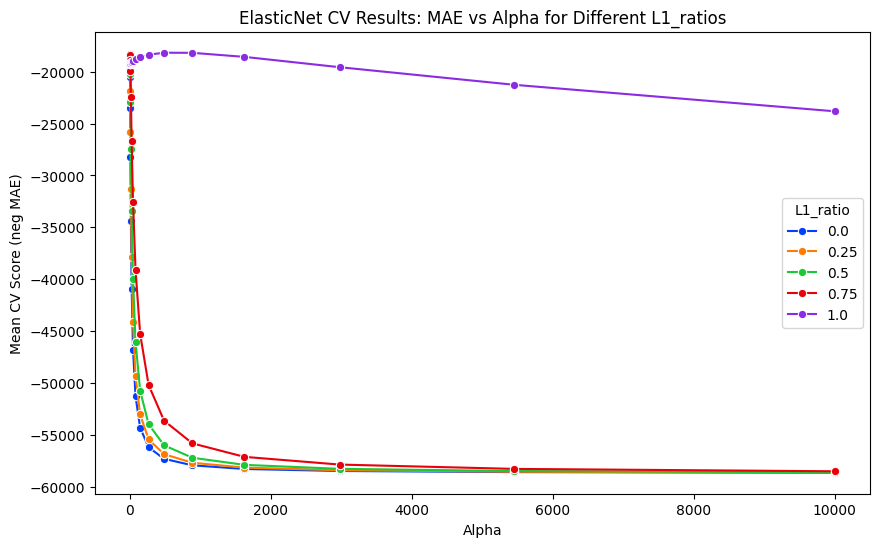

In [130]:
# summarize the results of the last cross-validation on the plot

elastic_search_df = pd.DataFrame(elastic_search.cv_results_)

plt.figure(figsize=(10, 6))
sns.lineplot(
    x = 'param_model__alpha',
    y = 'mean_test_score',
    hue = 'param_model__l1_ratio',
    data = elastic_search_df,
    palette = 'bright',
    marker = 'o'
)

#plt.xscale('log')  # if alpha is log-spaced, it is often nice to see on a log scale
plt.xlabel('Alpha')  # (Alpha log-scale) did not work 
plt.ylabel('Mean CV Score (neg MAE)')
plt.title('ElasticNet CV Results: MAE vs Alpha for Different L1_ratios')
plt.legend(title='L1_ratio')
plt.show()

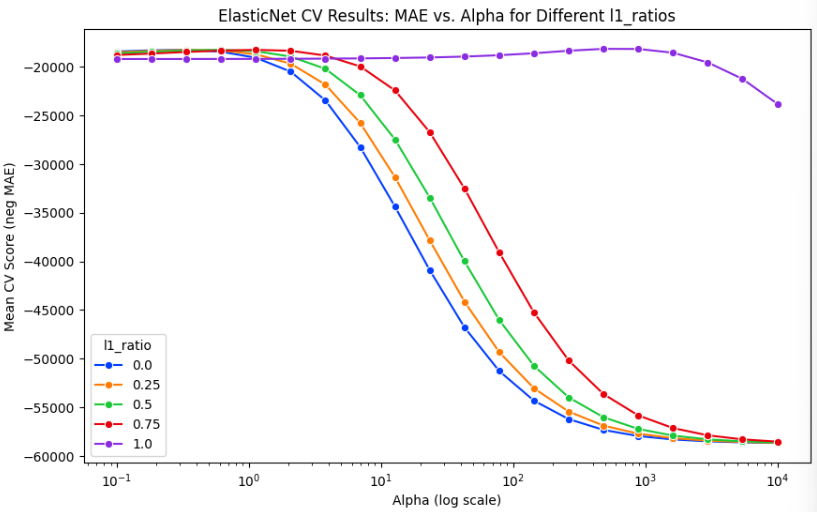

## Application of Regularization in Classification Problems

In [135]:
# laod the churn dataset AFTER recoding from a pickle file

churn_train_encoded = pd.read_pickle('data/churn_train_encoded.pkl')
churn_test_encoded = pd.read_pickle('data/churn_test_encoded.pkl')

churn_train_encoded.head()

,customer_id,customer_age,customer_number_of_dependents,customer_education,customer_salary_range,customer_relationship_length,customer_available_credit_limit,total_products,period_inactive,contacts_in_last_year,...,average_utilization,customer_gender_M,customer_gender_Unknown,customer_civil_status_Married,customer_civil_status_Single,customer_civil_status_Unknown,credit_card_classification_Gold,credit_card_classification_Platinum,credit_card_classification_Silver,account_status_1
4694,799562,50.0,2.0,2.0,1.0,37.0,13384.0,1.0,3.0,2.0,...,0.000,0,0,1,0,0,0,0,1,0
1263,282706,52.0,1.0,2.0,5.0,36.0,31945.0,4.0,3.0,5.0,...,0.050,1,0,0,0,0,0,0,0,0
4427,837683,46.0,3.0,1.0,3.0,36.0,5489.0,5.0,1.0,2.0,...,0.217,1,0,0,1,0,0,0,0,0
8746,384742,53.0,5.0,0.0,4.0,48.0,9517.0,6.0,1.0,0.0,...,0.196,1,0,1,0,0,0,0,0,0
4386,618362,59.0,0.0,4.0,2.0,53.0,4241.0,3.0,2.0,3.0,...,0.000,1,0,1,0,0,0,0,0,0


In [137]:
churn_train_X = churn_train_encoded.drop(['account_status_1', 'customer_id'], axis = 1)
churn_train_y = churn_train_encoded['account_status_1']

In [139]:
# using regularization is simple here as the function LogisticRegression directly
# allows for it with the penalty = argument

# the only difference is that we have to provide 1/lambda here as a C = parameter

# Initialize LASSO Logistic Regression model with lambda = 0.1
lasso_logreg = LogisticRegression(
    penalty = 'l1', # use L1 penalty for LASSO, L2 for Ridge
    C = 1/0.1,      # Convert lambda to C (C = 1 / lambda)
    solver = 'saga', # use 'saga' solver for L1 regularization
    max_iter = 2000,
    tol = 0.01,
    random_state = 123
)

# Evaluate the model using K-Fold Cross-Validation with balanced accuracy
lasso_logreg_cv_scores = cross_val_score(
    lasso_logreg,
    churn_train_X,
    churn_train_y,
    cv = cv5,
    scoring = 'roc_auc'
)

print('Cross-Validation AUROC Scores:', lasso_logreg_cv_scores)
print('Mean CV AUROC:', np.mean(lasso_logreg_cv_scores))

Cross-Validation AUROC Scores: [0.70597291 0.66955312 0.72130445 0.73153671 0.72980789]
Mean CV AUROC: 0.7116350168759178


In [143]:
# check Ridge with the same lambda

# Initialize ridge logistic regression model with lambda = 0.1
ridge_logreg = LogisticRegression(
    penalty = 'l2',       # Use L1 penalty for LASSO, l2 for ridge
    C = 1/0.1,           # Convert lambda to C (C = 1 / lambda)
    solver = 'saga',      # Use 'saga' solver for L1 regularization
    max_iter = 2000,
    tol = 0.01,
    random_state = 123
)

# Evaluate the model using K-Fold cross-validation with balanced accuracy
ridge_logreg_cv_scores = cross_val_score(
    ridge_logreg,
    churn_train_X,
    churn_train_y,
    cv = cv5,
    scoring = 'roc_auc'
)

# Print cross-validation balanced accuracy scores
print("Cross-Validation AUROC Scores:", ridge_logreg_cv_scores)
print("Mean CV AUROC:", np.mean(ridge_logreg_cv_scores))

Cross-Validation AUROC Scores: [0.70597291 0.66955312 0.72130445 0.73153671 0.72980789]
Mean CV AUROC: 0.7116350168759178


In [145]:
# elastic-net also works

# Initialize elasticnet logistic regression model with lambda = 0.1
elastic_logreg = LogisticRegression(
    penalty = 'elasticnet',
    l1_ratio = 0.5, # needed for elastic net
    C = 1/0.1,      # Convert lambda to C (C = 1 / lambda)
    solver = 'saga', # use 'saga' solver for L1 regularization
    max_iter = 2000,
    tol = 0.01,
    random_state = 123
)

elastic_logreg_cv_scores = cross_val_score(
    ridge_logreg,
    churn_train_X,
    churn_train_y,
    cv = cv5,
    scoring = 'roc_auc'
)

print("Cross-Validation AUROC Scores:", elastic_logreg_cv_scores)
print("Mean CV AUROC:", np.mean(elastic_logreg_cv_scores))

Cross-Validation AUROC Scores: [0.70597291 0.66955312 0.72130445 0.73153671 0.72980789]
Mean CV AUROC: 0.7116350168759178
